## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

Ипортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

Создадим функцию по проведению bootstrap

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Считаем данные из локального файла, посмотрим на размерность, типы данных, количество пропущенных значений

In [3]:
data = pd.read_csv('hw_bootstrap.csv', sep=';', index_col=0)
data.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


In [4]:
data.shape

(1000, 2)

In [5]:
data.dtypes

value                object
experimentVariant    object
dtype: object

In [6]:
data.isna().sum()

value                0
experimentVariant    0
dtype: int64

Приведем колонку value к численному значению

In [7]:
data['value'] = data['value'].str.replace(',', '.').astype(float)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


Проверим количество групп участвующих в эксперименте

In [9]:
data.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

Проверим количество наблюдений в каждой из групп

In [11]:
print('control sample consist of ', data.query('experimentVariant == "Control"').experimentVariant.count(), 'observations')
print('treatment sample consist of ', data.query('experimentVariant == "Treatment"').experimentVariant.count(), 'observations')

control sample consist of  500 observations
treatment sample consist of  500 observations


Выведем описательные статистики каждой из групп

In [14]:
data.query('experimentVariant == "Control"').value.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

In [15]:
data.query('experimentVariant == "Treatment"').value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

В группе Treatment заметны сильные выбросы что существенно повлияло на величину стандартного отклонения

Посмотрим на графическое представление распределений двух групп

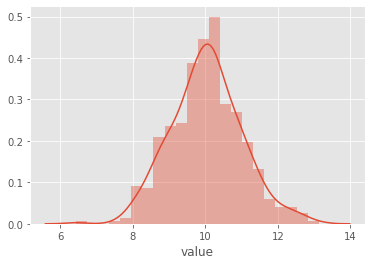

In [16]:
sns.distplot(data.query('experimentVariant == "Control"').value)

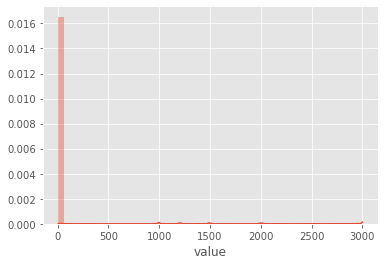

In [17]:
sns.distplot(data.query('experimentVariant == "Treatment"').value)

В группе Treatment заметно влияние выбросов, попробуем прологарифмировать и посмотреть на получившееся распределение

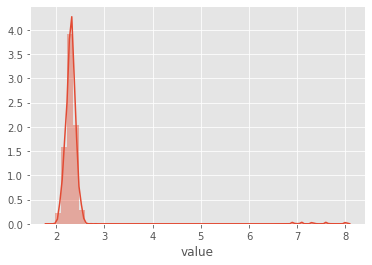

In [19]:
sns.distplot(np.log(data.query('experimentVariant == "Treatment"').value))

Логарифм также показывает заметные выбросы

Посмотрим на более репрезентативную визуализацию в части распределений - boxplot

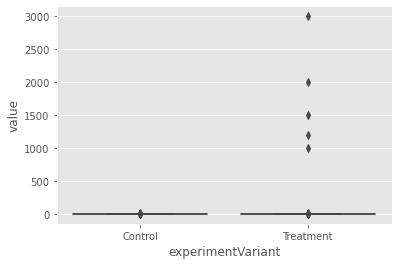

In [20]:
sns.boxplot(x='experimentVariant', y='value', data=data)

Как видим из графика небольшое количество значений формируют сильный разброс в данных, визульно сравним распределения без указанных выбросов

In [21]:
data_no_outliers = data.query('value < 1000')

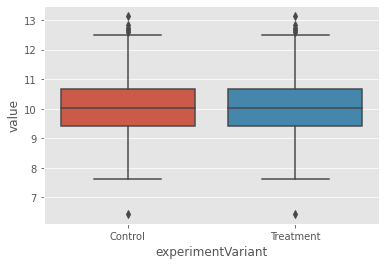

In [22]:
sns.boxplot(x='experimentVariant', y='value', data=data_no_outliers)

Распределения визульно очень похожи, применим соответствующие статистические тесты, чтобы проверить гипотезу о статзначимом отличии двух выборок

Сформируем гипотезы:
<b>H0</b> - выборки не отличаются между собой по значению сопоставляемого признака
<b>H1</b> - выборки отличаются между собой по значению сопоставляемого признака

Разобьем датасет на группы и применим статтест

In [23]:
# будем пробовать бутстрап на эксп. распределении
x = data.query('experimentVariant == "Control"').value.values
y = data.query('experimentVariant == "Treatment"').value.values


df = pd.DataFrame({"x": x, "y": y})

В первую очередь испытаем bootstrap на различие средних значений

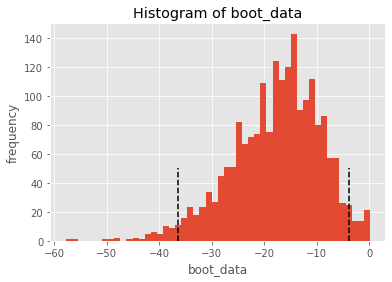

In [24]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [25]:
booted_data["p_value"]

0.03611505004321999

In [26]:
booted_data["ci"]

,0
0.025,-36.382396
0.975,-3.868703


В данном эксперименте bootstrap показывает статистически значимые различия средних двух групп. p-value < 0.05

Применим непараметрический тест Mann-Whitney, не чувствительный к выбросам

In [28]:
mannwhitneyu(x, y, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Величина pvalue=0.8592148582485579 теста Mann-Whitney которая значительно больше > 0.05 говорит нам о том, что у нас не достаточно оснований отклонить нулевую гипотезу H0

Применим bootstrap для сопоставления медианных значений двух выборок (медиана менее чувствительна к выбросам)

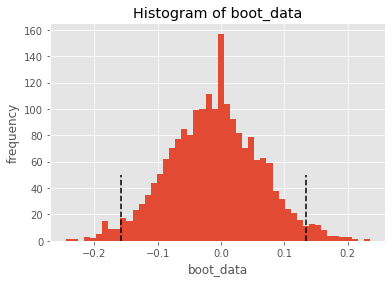

In [29]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000, statistic=np.median)

In [30]:
booted_data["p_value"]

0.8813229994509403

In [31]:
booted_data["ci"]

,0
0.025,-0.157859
0.975,0.134598


Величина pvalue=0.8813229994509403 теста bootstrap, при оценке параметра медиана, которая значительно больше > 0.05 говорит нам о том, что у нас не достаточно оснований отклонить нулевую гипотезу H0 о равенстве медианных значений

<b>Вывод:</b> статистически значимые различия выборок в группах Treatment и Control при оценке различия средних значений вероятнее всего получены в результате привнесенного шума в виде выбросов в группе Treatment. Исходя из полученных результатов можно утверждать что у нас не достаточно оснований утверждать что выбранные группы статистически значимо отличаются.